In [389]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
import xgboost as xgb

In [390]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [391]:
print train.shape, test.shape

(891, 12) (418, 11)


In [392]:
Y_train = train.Survived
test_id = test.PassengerId

In [393]:
train_test = pd.concat([train, test])
train_test = train_test.drop(['PassengerId', 'Survived', 'Name', 'Cabin', 'Ticket'], axis = 1)
print 'shape: '
print train_test.shape, train.shape, test.shape
print '~~~~~~~~~~~~~'
print 'type'
print train_test.dtypes
print '~~~~~~~~~~~~~'
print 'No. of Nans'
print train_test.isnull().sum()
print '~~~~~~~~~~~~~'
train_test.head(2)

shape: 
(1309, 7) (891, 12) (418, 11)
~~~~~~~~~~~~~
type
Age         float64
Embarked     object
Fare        float64
Parch         int64
Pclass        int64
Sex          object
SibSp         int64
dtype: object
~~~~~~~~~~~~~
No. of Nans
Age         263
Embarked      2
Fare          1
Parch         0
Pclass        0
Sex           0
SibSp         0
dtype: int64
~~~~~~~~~~~~~


,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.0,S,7.2500,0,3,male,1
1,38.0,C,71.2833,0,1,female,1


In [394]:
print 'fill NaNs with mean or mode for object type'
train['Age'].fillna((train['Age'].mean()), inplace=True)
train['Fare'].fillna((train['Fare'].mean()), inplace=True)
train['Embarked'].fillna((train.Embarked.value_counts()[0]), inplace=True)
test['Age'].fillna((test['Age'].mean()), inplace=True)
test['Fare'].fillna((test['Fare'].mean()), inplace=True)
test['Embarked'].fillna((test.Embarked.value_counts()[0]), inplace=True)
train_test = pd.concat([train, test])
train_test = train_test.drop(['PassengerId', 'Survived', 'Name', 'Cabin', 'Ticket'], axis = 1)

print 'No. of Nans'
print train_test.isnull().sum()
train_test.head(2)

fill NaNs with mean or mode for object type
No. of Nans
Age         0
Embarked    0
Fare        0
Parch       0
Pclass      0
Sex         0
SibSp       0
dtype: int64


,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.0,S,7.2500,0,3,male,1
1,38.0,C,71.2833,0,1,female,1


In [395]:
print 'process object types: ["Embarked", "Sex"]'
train_test['Embarked'] = train_test['Embarked'].factorize()[0]
train_test = pd.concat([train_test, pd.get_dummies(train_test.Sex)], axis = 1)
train_test = train_test.drop(['Sex'], axis = 1)
print train_test.dtypes
train_test.head()

process object types: ["Embarked", "Sex"]
Age         float64
Embarked      int64
Fare        float64
Parch         int64
Pclass        int64
SibSp         int64
female        uint8
male          uint8
dtype: object


,Age,Embarked,Fare,Parch,Pclass,SibSp,female,male
0,22.0,0,7.2500,0,3,1,0,1
1,38.0,1,71.2833,0,1,1,1,0
2,26.0,0,7.9250,0,3,0,1,0
3,35.0,0,53.1000,0,1,1,1,0
4,35.0,0,8.0500,0,3,0,0,1


In [396]:
train_test.describe()

,Age,Embarked,Fare,Parch,Pclass,SibSp,female,male
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.882243,0.398778,33.297261,0.385027,2.294882,0.498854,0.355997,0.644003
std,12.883758,0.661200,51.738919,0.865560,0.837836,1.041658,0.478997,0.478997
min,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,7.895800,0.000000,2.000000,0.000000,0.000000,0.000000
50%,29.699118,0.000000,14.454200,0.000000,3.000000,0.000000,0.000000,1.000000
75%,35.000000,1.000000,31.275000,0.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,3.000000,512.329200,9.000000,3.000000,8.000000,1.000000,1.000000


In [2]:
def normalize(columns):
    for col in columns:
        mu = train[col].mean()
        sigma = train[col].std()
        train_test[col] = (train[col] - train[col].mean())/train[col].std()

In [3]:
print 'normalize columns ["Age", "Fare"]: '
columns_to_normalize = ['Age', 'Fare']
normalize(columns_to_normalize)
train_test.describe()

normalize columns ["Age", "Fare"]: 


NameError: global name 'train' is not defined

In [399]:
X_train = train_test[:len(train)]
X_test = train_test[len(train):]
print X_train.shape, X_test.shape

(891, 8) (418, 8)


In [400]:
print X_train.shape, Y_train.shape
X_train, X_cv, Y_train, Y_cv = model_selection.train_test_split(X_train, Y_train, test_size=0.3)
print X_train.shape, Y_train.shape
print X_cv.shape, Y_cv.shape

(891, 8) (891,)
(623, 8) (623,)
(268, 8) (268,)


# Logistic regression

In [401]:
def sigmoid(x):
    x = np.array(x)
    return 1/(1+np.exp(-x))

In [402]:
def logistic_regression_cost_and_gradient(X_train, Y_train, theta, la):
    # return cost J and gradient of theta in grad
    m = len(Y_train)
    X = X_train.copy()
    X.insert(0, 'Bias', 1)
    X = np.array(X)
    Y = np.array(Y_train)
    h_theta = sigmoid(np.dot(X, theta))
    J = -(np.dot(Y, np.log(h_theta)) + np.dot(1-Y, np.log(1-h_theta))) / m + np.dot(theta[1:], theta[1:])*la / (2*m)
    grad = np.dot(X.transpose(), h_theta - Y) / m + theta*la / m
    grad[0] = grad[0] - theta[0]*la / m     
    return [J, grad]

In [403]:
def logistic_regression_model(X_train, Y_train, theta, la = 1, alpha = 0.1, epsilon = 10.0**(-5), max_iterators = 10**4):
    # return cost J and optimal theta 
    [J, grad] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, la)
    cost = [J]
    for i in range(max_iterators):
        theta = theta - alpha * grad
        [J, grad] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, la)
        if abs(cost[-1] - J) < epsilon:
            break
        cost.append(J)
        
    plt.plot(cost)
    plt.title('alpha = %r, lambda = %r'% (alpha, la))
    plt.xlabel('No. of iterations')
    plt.ylabel('Cost function J')
    plt.show()
    
    return [J, theta]

In [404]:
def logistic_regression_cross_validation(X_train, X_cv, Y_train, Y_cv, lambdas, alphas):
    init_theta = np.zeros(X_train.shape[1] + 1)
    alpha_best = alphas[0]
    lambda_best = lambdas[0]
    theta_best = init_theta
    J_best = float("inf")
    for alpha in alphas:
        Js = []
        J_train = []
        J_cv = []
        thetas = []
        for i in range(len(lambdas)):
            [J, theta] = logistic_regression_model(X_train, Y_train, init_theta, lambdas[i], alpha)
            Js.append(J)
            [J_train_i, grad_train] = logistic_regression_cost_and_gradient(X_train, Y_train, theta, 0)
            if len(J_train) > 0 and J_train[-1] > J_train_i:
                break
            J_train.append(J_train_i)
            [J_cv_i, grad_cv] = logistic_regression_cost_and_gradient(X_cv, Y_cv, theta, 0)
            J_cv.append(J_cv_i)
            if len(J_train) > 0 and J_train[-1] > J_cv[-1]:
                break
            if len(J_cv) == 2 and J_cv[1] > J_cv[0]:
                break
            thetas.append(theta)
        if len(thetas) != len(lambdas):
            continue

        plot_train, = plt.plot(lambdas, J_train, label='J_train')
        plot_cv, = plt.plot(lambdas, J_cv, label='J_cv')
        plt.title('Cross Validation')
        plt.xlabel('lambda')
        plt.ylabel('Cost function J')
        plt.legend([plot_train, plot_cv], ["J_train", "J_cv"])
        plt.show()
        
        idx = J_cv.index(min(J_cv))
        if idx != 0 and idx != len(J_cv) - 1:
            if Js[idx] < J_best:
                J_best = Js[idx]
                alpha_best = alpha
                lambda_best = lambdas[idx]
                theta_best = thetas[idx]
                print 'update parameters: '
                print 'cost = %r ' % J 
                print 'best alpha = %r' % alpha_best
                print 'best lambda = %r' % lambda_best
                print 'best theta = %r' % theta_best

    return [alpha_best, lambda_best, theta_best]

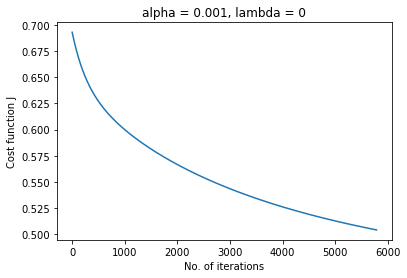

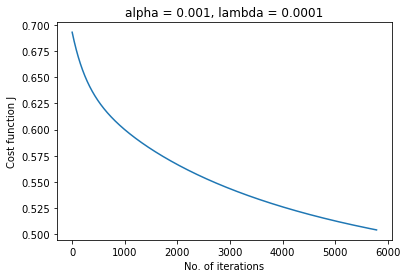

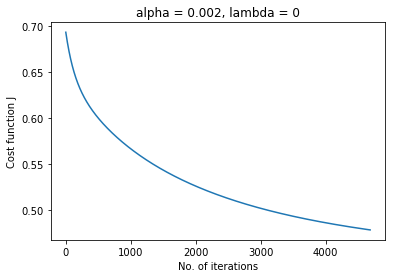

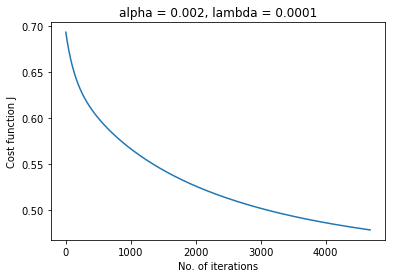

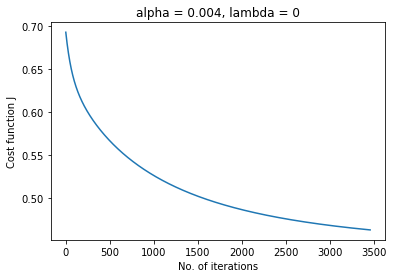

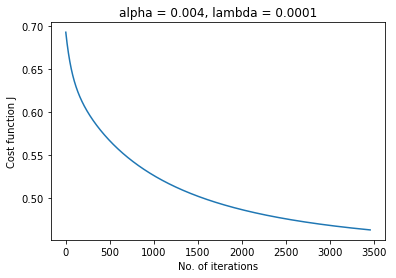

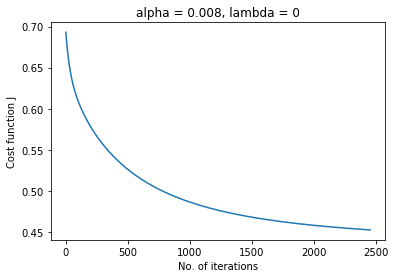

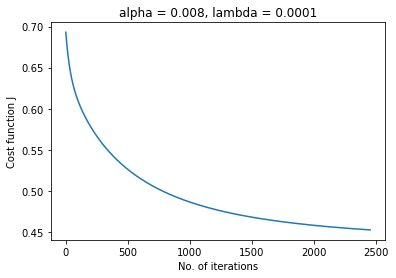

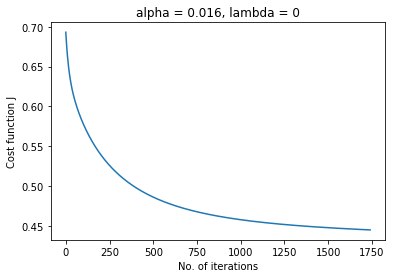

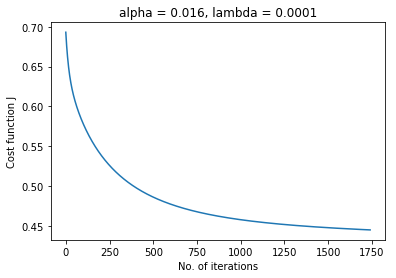

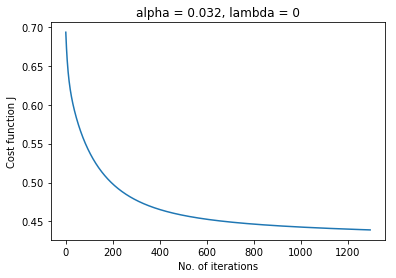

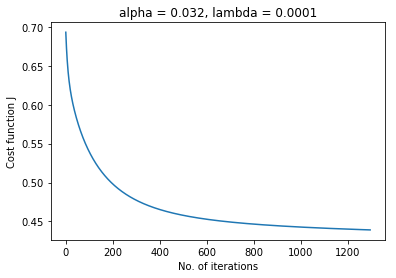

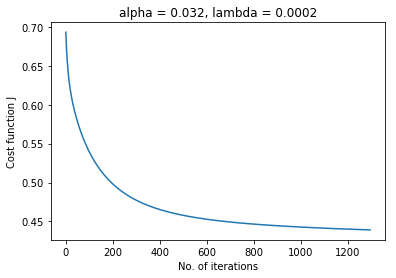

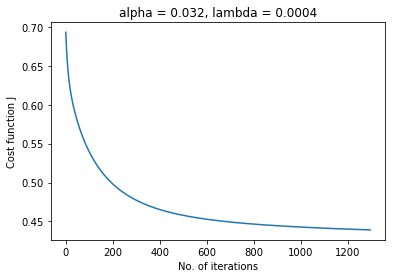

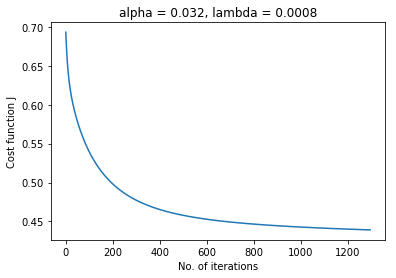

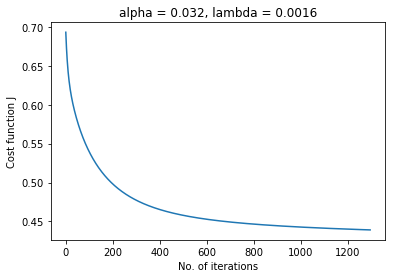

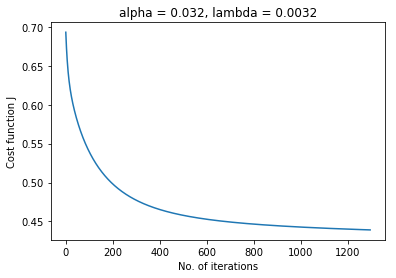

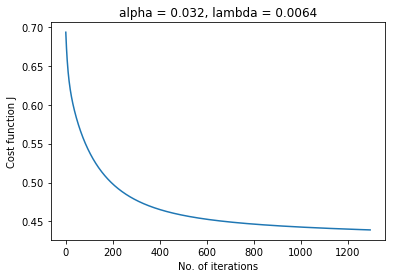

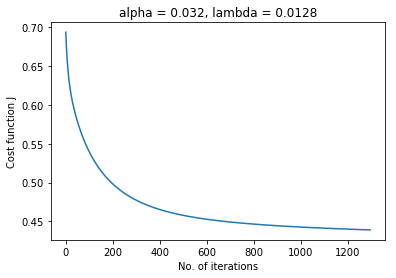

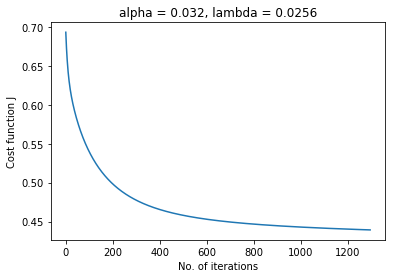

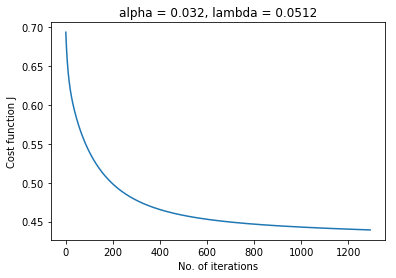

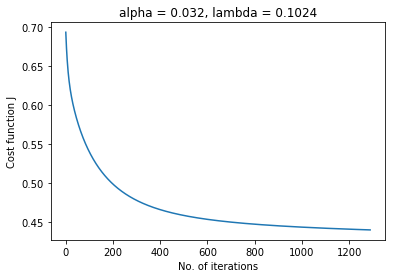

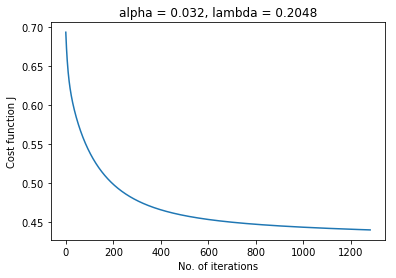

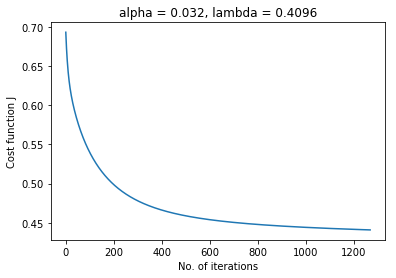

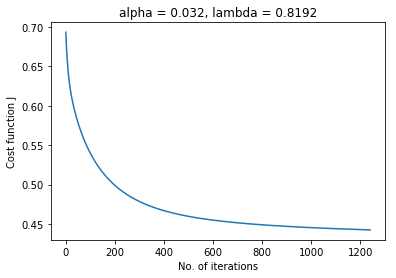

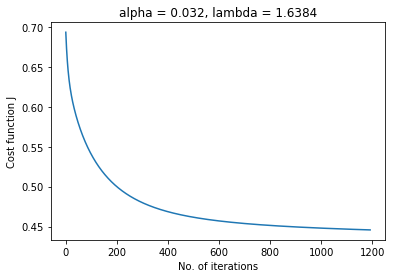

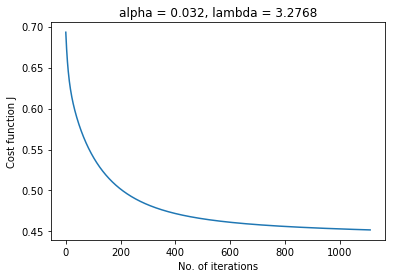

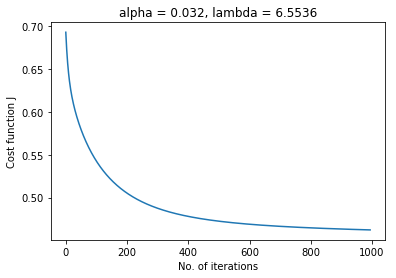

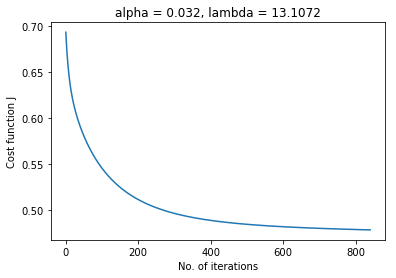

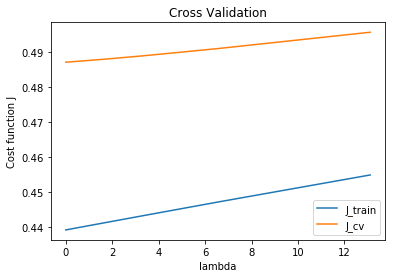

update parameters: 
cost = 0.47876875389197976 
best alpha = 0.032
best lambda = 0.0064
best theta = array([ 0.66971378, -0.32777374,  0.3100284 ,  0.47709612,  0.00249645,
       -0.53067357, -0.38398279,  1.53696334, -0.86740343])


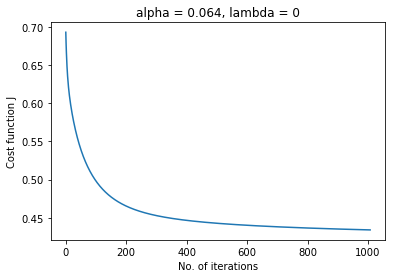

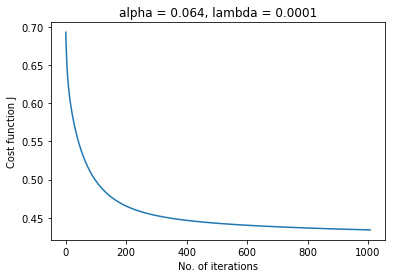

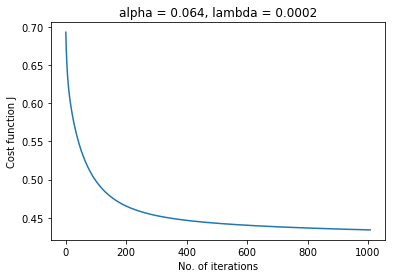

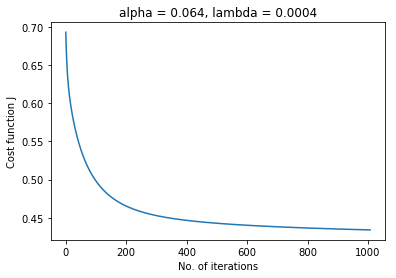

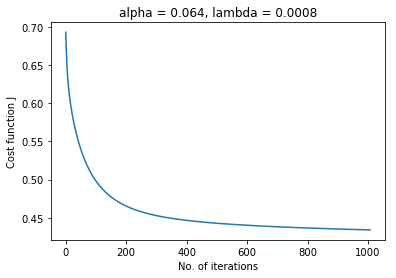

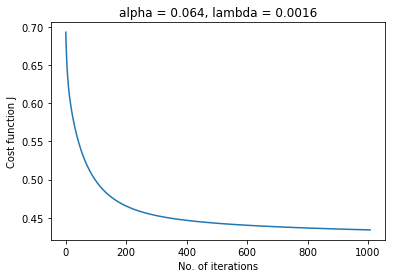

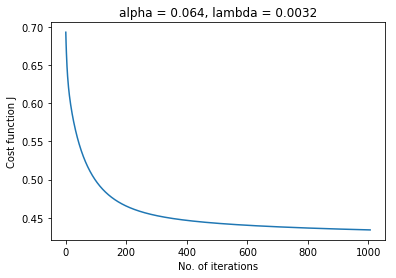

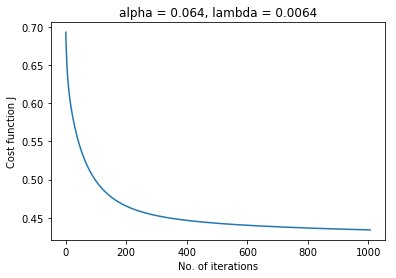

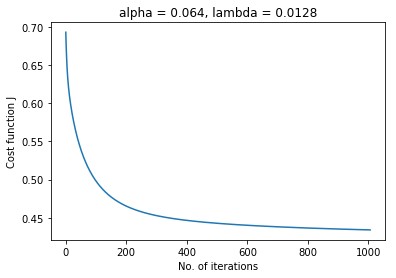

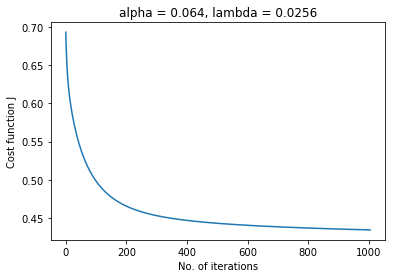

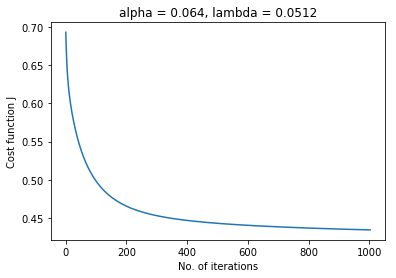

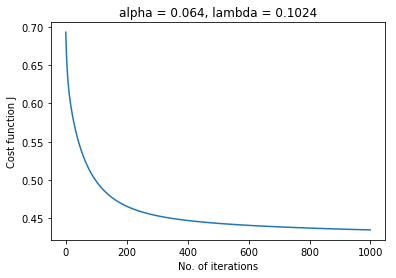

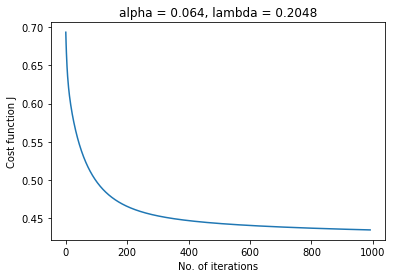

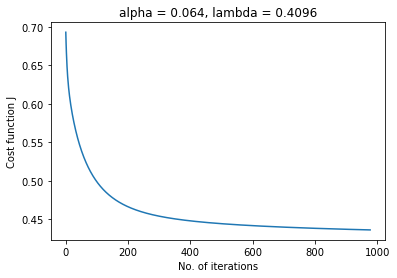

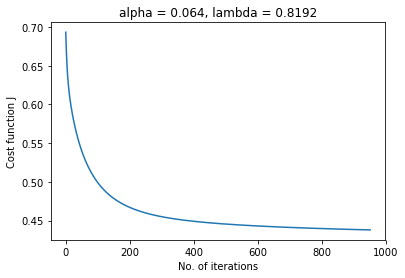

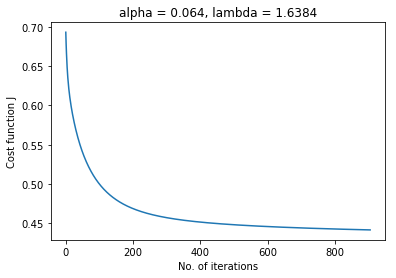

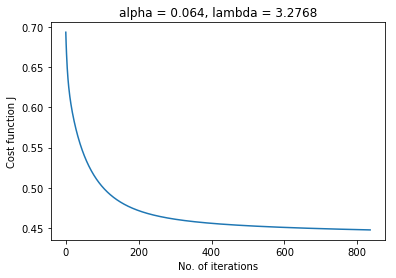

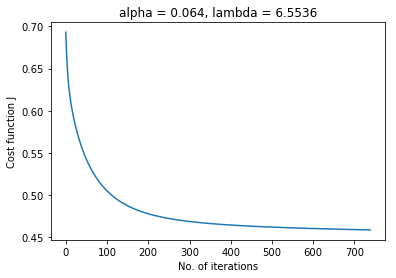

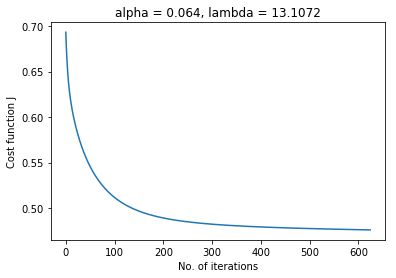

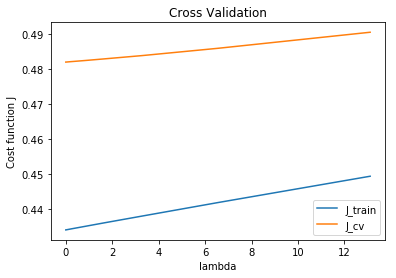

update parameters: 
cost = 0.47592996692907102 
best alpha = 0.064
best lambda = 0.0016
best theta = array([ 0.90288727, -0.37407128,  0.29611763,  0.43015737, -0.04095142,
       -0.65960972, -0.40291872,  1.72404996, -0.82124793])


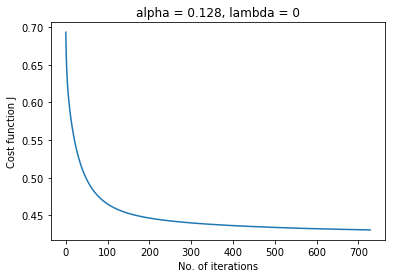

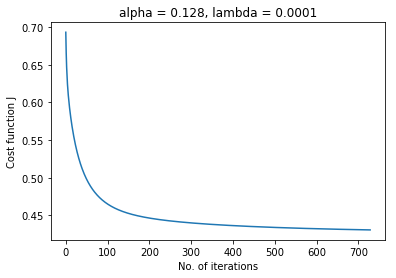

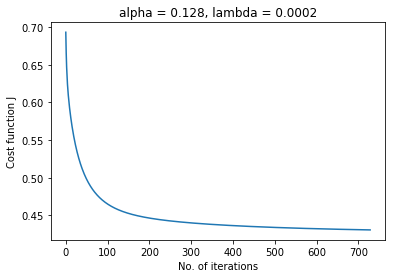

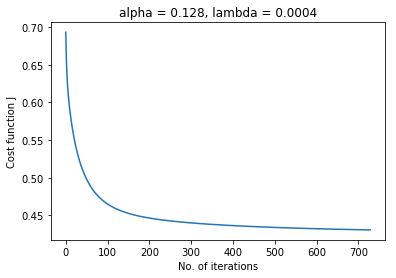

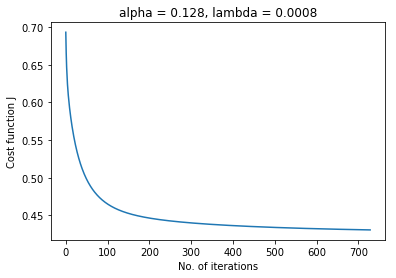

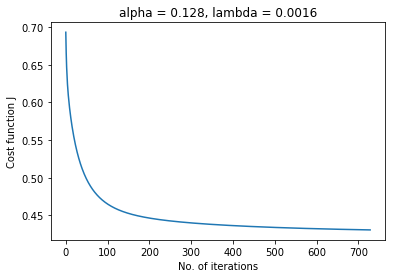

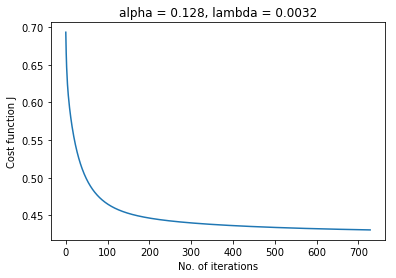

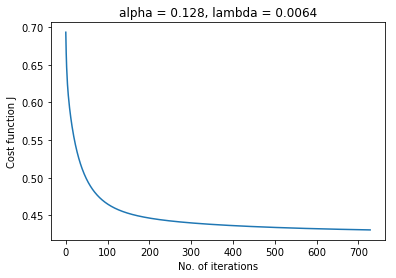

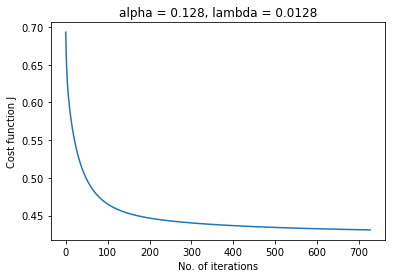

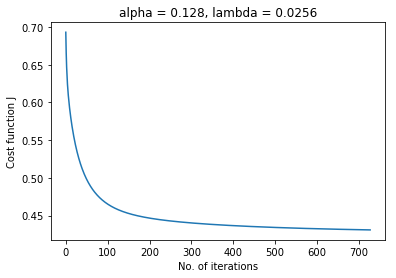

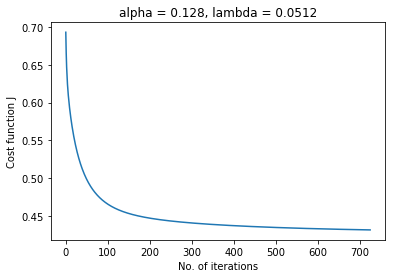

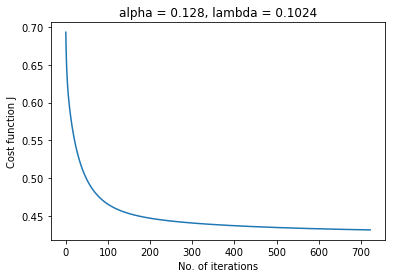

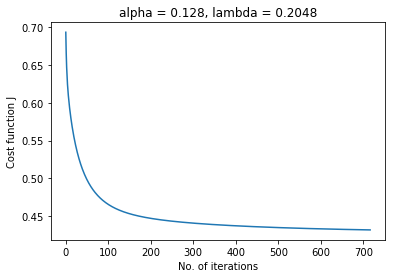

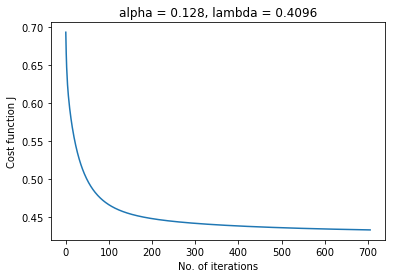

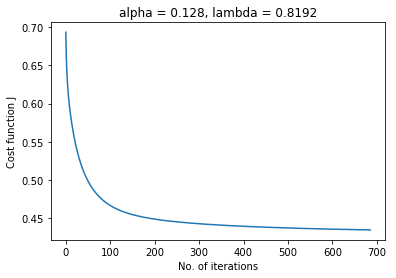

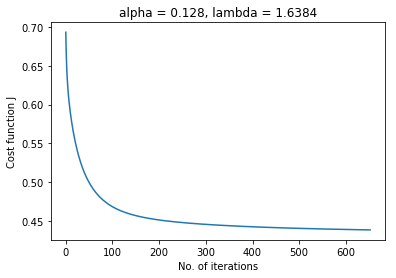

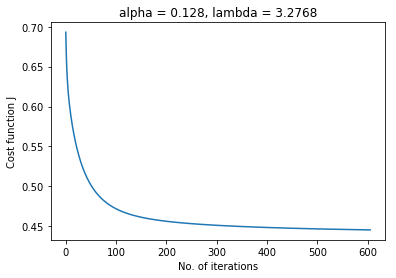

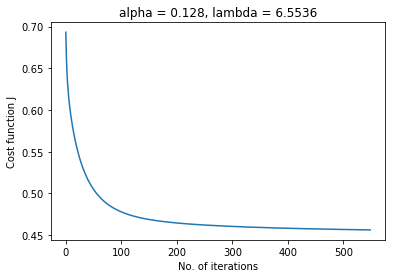

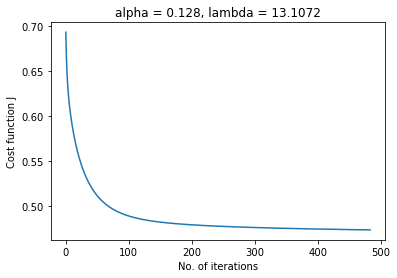

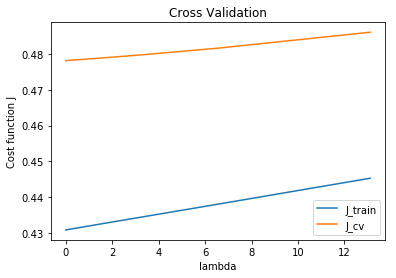

update parameters: 
cost = 0.47351761808274812 
best alpha = 0.128
best lambda = 0.0064
best theta = array([ 1.11418464, -0.41386508,  0.28809419,  0.36493802, -0.06189948,
       -0.78601554, -0.40854094,  1.86592169, -0.75237777])


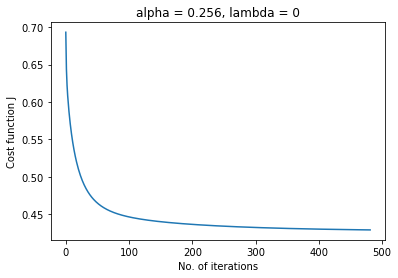

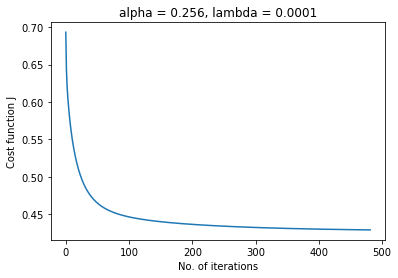

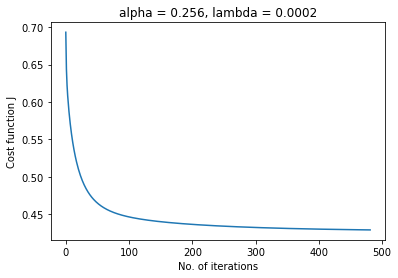

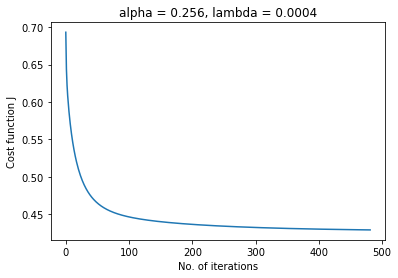

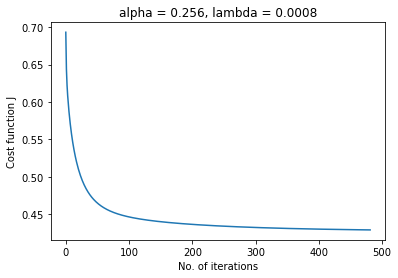

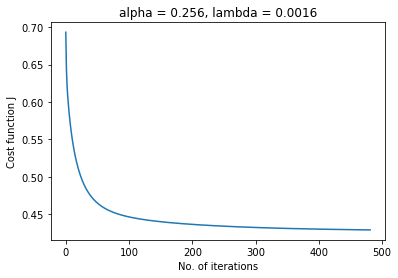

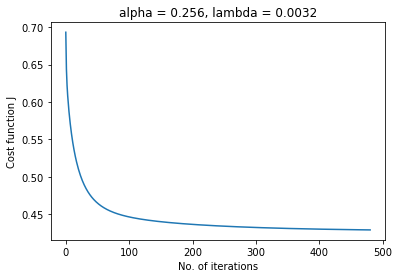

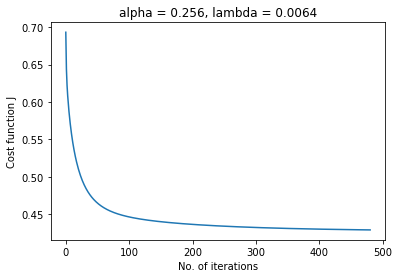

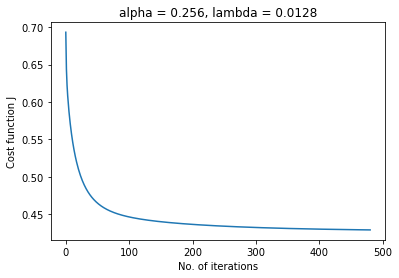

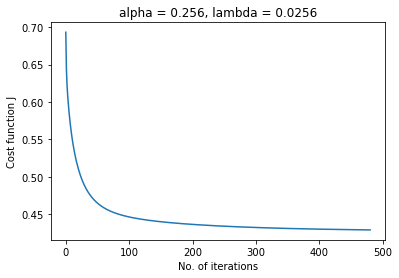

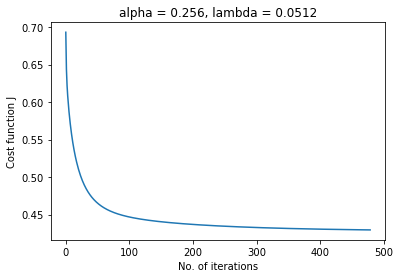

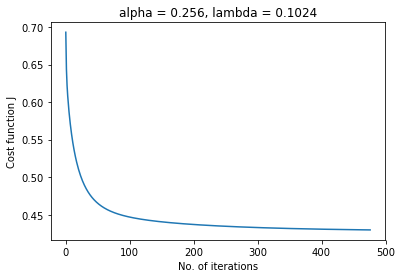

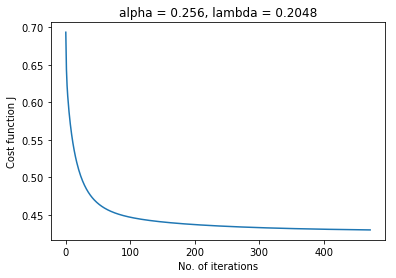

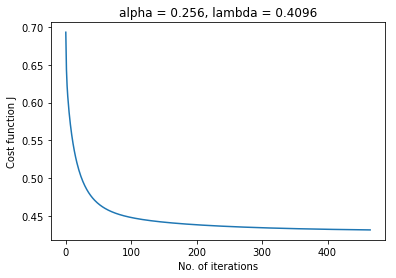

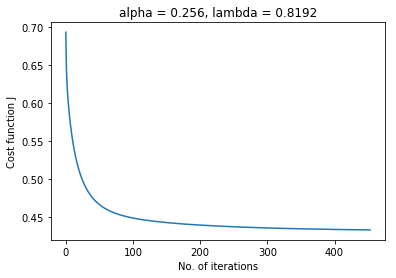

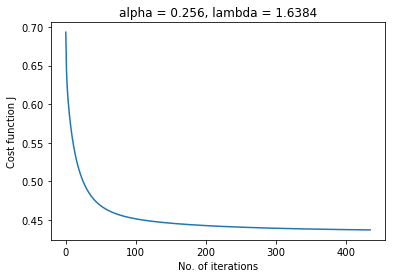

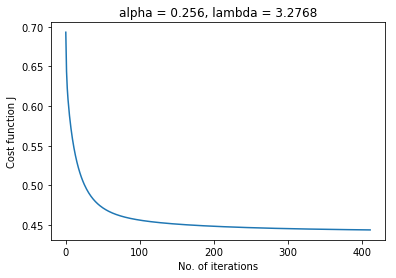

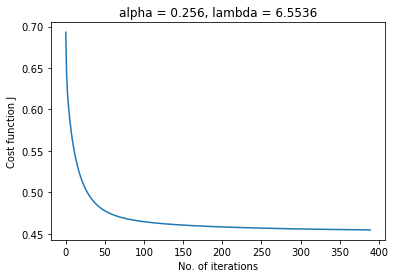

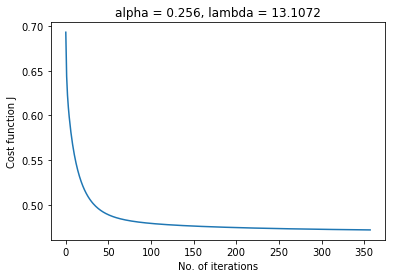

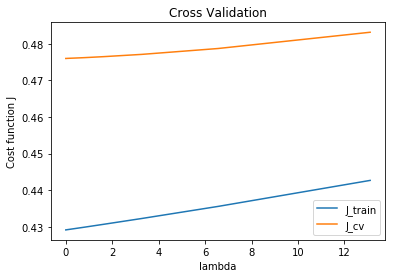

update parameters: 
cost = 0.47187217022866063 
best alpha = 0.256
best lambda = 0.0016
best theta = array([ 1.2701087 , -0.44294775,  0.28747347,  0.31129179, -0.0696051 ,
       -0.88302659, -0.41085626,  1.96555315, -0.69569701])


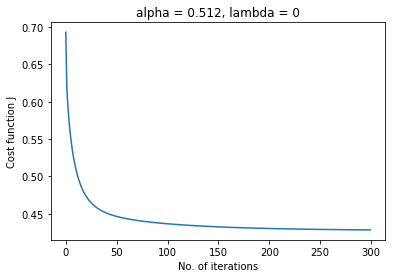

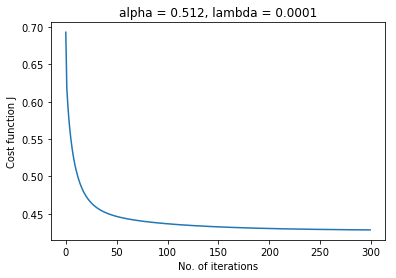

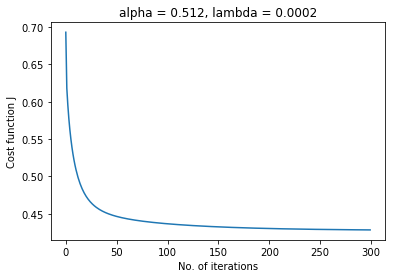

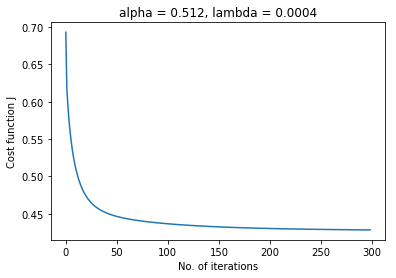

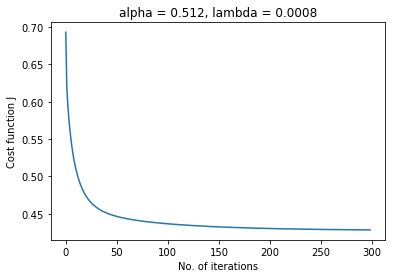

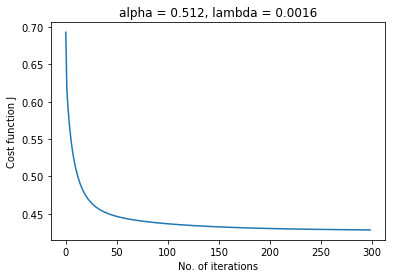

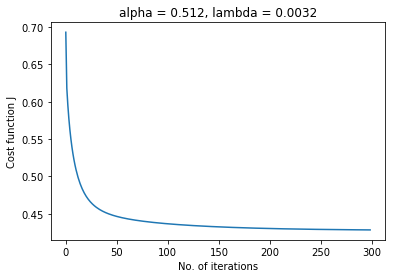

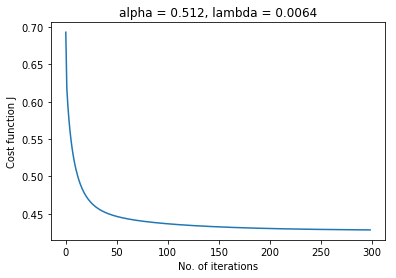

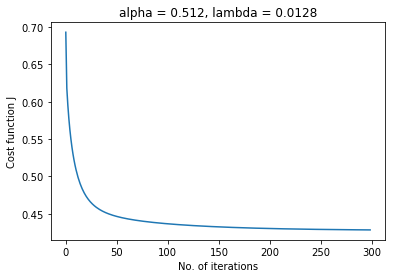

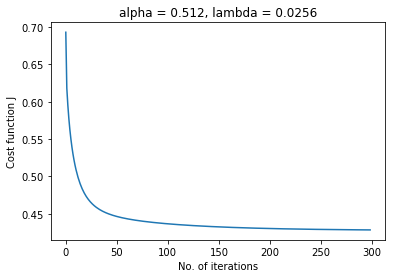

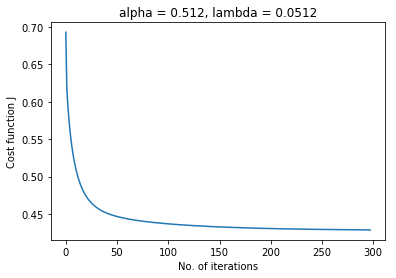

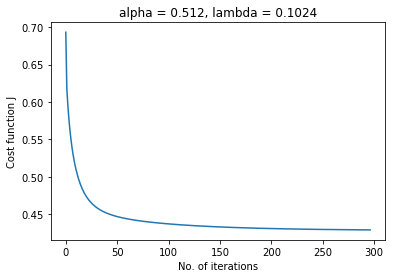

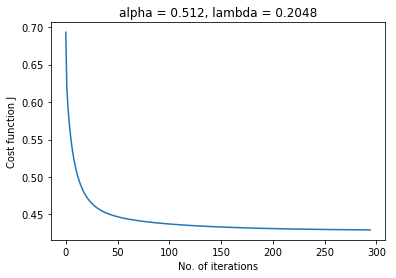

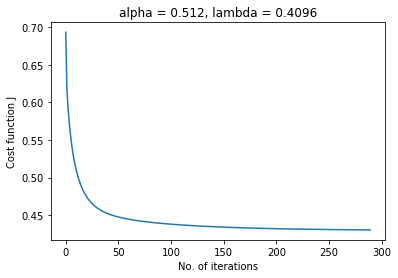

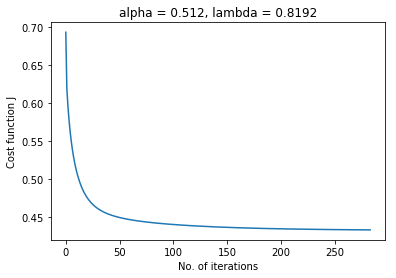

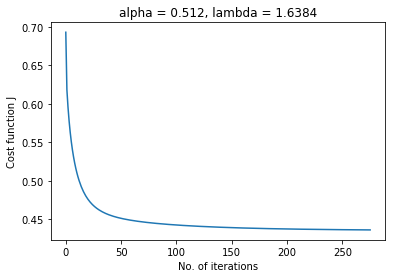

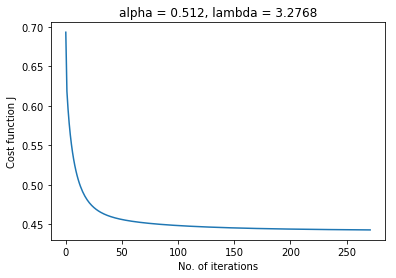

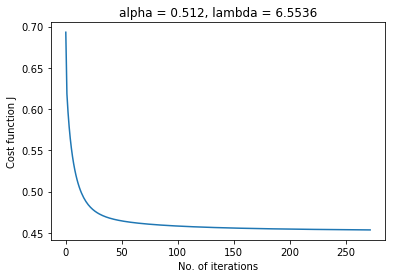

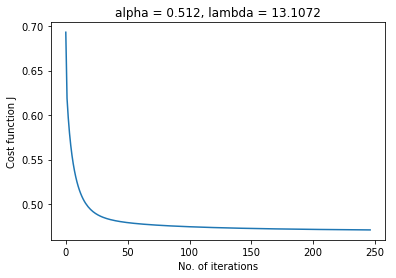

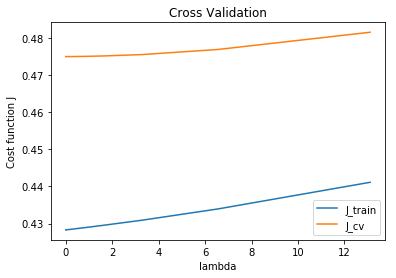

update parameters: 
cost = 0.47090067764069016 
best alpha = 0.512
best lambda = 0.0002
best theta = array([ 1.38096669, -0.46394126,  0.289254  ,  0.27406596, -0.07302411,
       -0.95272555, -0.41292928,  2.03583812, -0.65491587])


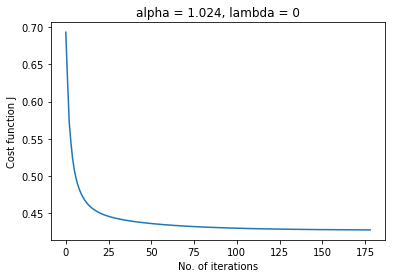

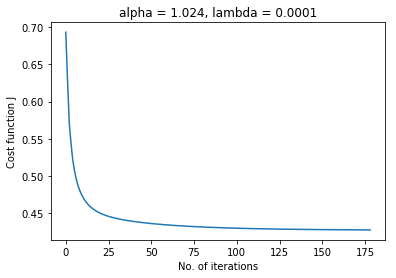

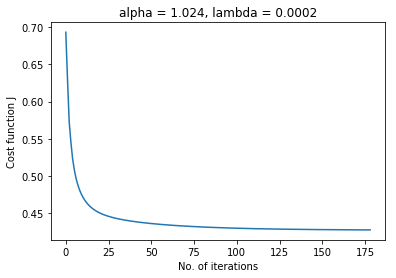

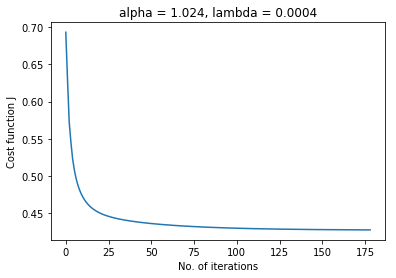

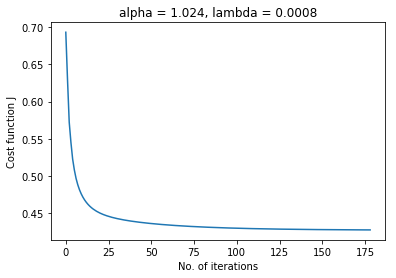

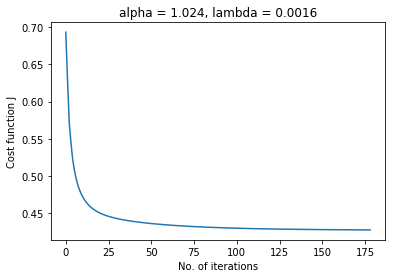

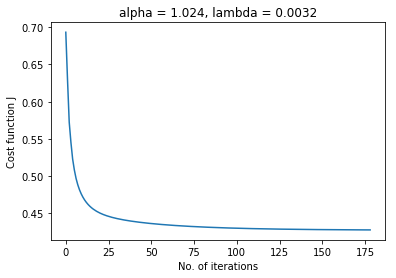

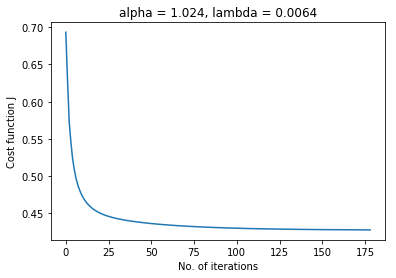

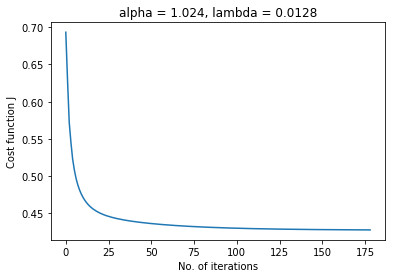

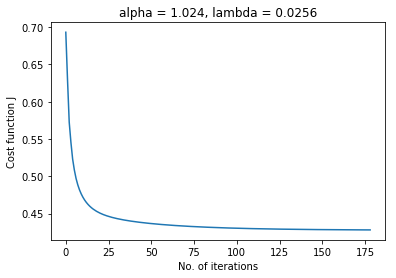

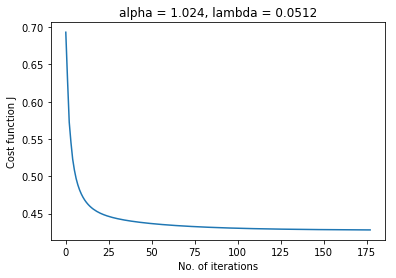

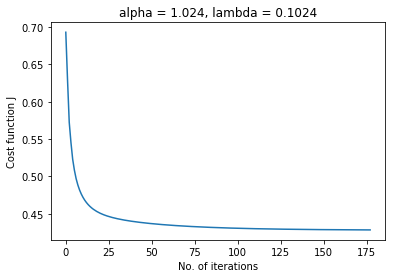

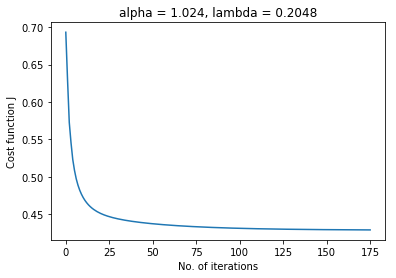

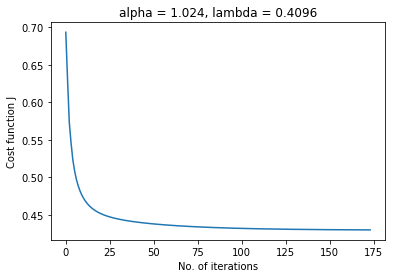

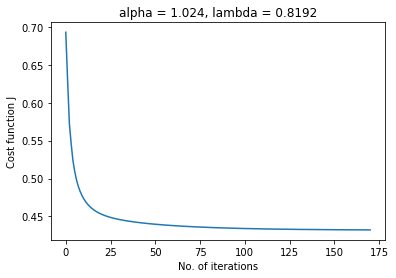

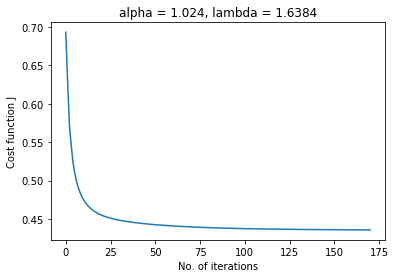

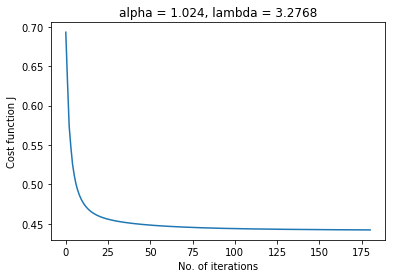

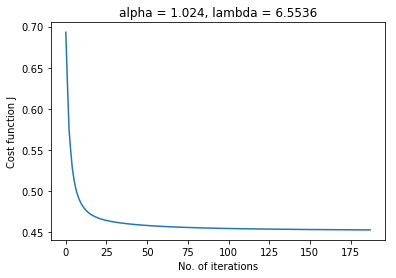

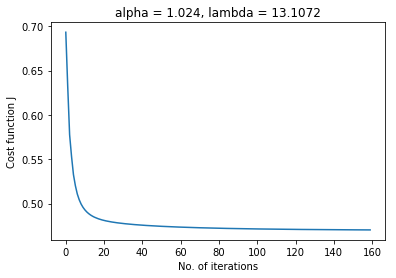

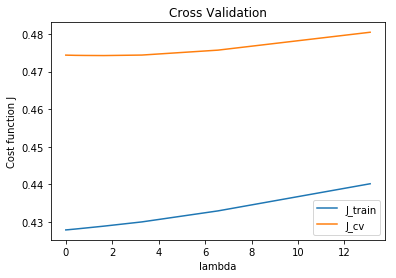

In [405]:
alphas = [10.0**(-3)*2**i for i in range(11)]
lambdas = [10.0**(-4)*2**i for i in range(17)]
lambdas.insert(0, 0)
[alpha_best, lambda_best, theta_best] = logistic_regression_cross_validation(X_train, X_cv, Y_train, Y_cv, lambdas, alphas)

In [406]:
print 'best alpha = %r' % alpha_best
print 'best lambda = %r' % lambda_best
print 'best theta = %r' % theta_best

best alpha = 0.512
best lambda = 0.0002
best theta = array([ 1.38096669, -0.46394126,  0.289254  ,  0.27406596, -0.07302411,
       -0.95272555, -0.41292928,  2.03583812, -0.65491587])


In [407]:
def logistic_regression_predict(theta, X_test):
    X = X_test.copy()
    X.insert(0, 'Bias', 1)
    X = np.array(X)
    predict = sigmoid(np.dot(X, theta))
    return predict

In [408]:
print 'predict result by logistic regression:'
y_predict_lr = logistic_regression_predict(theta_best, X_test)
y_predict = [1 if p > 0.5 else 0 for p in y_predict_lr]
# print len(test_id), len(y_predict_lr)
output_lr = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict})
print output_lr.Survived.value_counts()
# output_lr.to_csv('Titanic_lr.csv', index=False)
output_lr.head()

predict result by logistic regression:
0    261
1    157
Name: Survived, dtype: int64


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


# Xgboost

In [409]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'rmse',
    'silent': 0
}

In [410]:
dtrain = xgb.DMatrix(X_train, Y_train)
dcv = xgb.DMatrix(X_cv)
dtest = xgb.DMatrix(X_test)
xgboost_model = xgb.train(dict(xgb_params), dtrain, num_boost_round=1000)

In [411]:
print 'predict result by xgboost:'
y_predict_xgb = xgboost_model.predict(dtest)
y_predict = [1 if p > 0.5 else 0 for p in y_predict_xgb]
# print len(test_id), len(y_predict_xgb)
output_xgb = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict})
print output_xgb.Survived.value_counts()
# output_xgb.to_csv('Titanic_xgb.csv', index=False)
output_xgb.head()

predict result by xgboost:
0    269
1    149
Name: Survived, dtype: int64


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# Ensemble of the two models

In [432]:
def f1_score(Y_cv_predict, Y_cv):
    tp = np.dot(Y_cv_predict, Y_cv)
    fp = np.dot(Y_cv_predict, 1 - Y_cv)
    fn = np.dot(1 - np.array(Y_cv_predict), Y_cv)

    precision = float(tp)/(tp + fp)
    recall = float(tp)/(tp + fn)
    f1 = 2*precision*recall/(precision + recall)
#     print tp, fp, fn, precision, recall, f1
    
    return f1

In [439]:
Y_cv_lr = logistic_regression_predict(theta_best, X_cv)
Y_cv_lr = [1 if p > 0.5 else 0 for p in Y_cv_lr]
Y_cv_xgb = xgboost_model.predict(dcv)
Y_cv_xgb = [1 if p > 0.5 else 0 for p in Y_cv_xgb]
w1 = round(f1_score(Y_cv_lr, Y_cv),3)
w2 = round(f1_score(Y_cv_xgb, Y_cv),3)
w1 = round(w1 / (w1 + w2),3)
w2 = 1 - w1
print 'logistic_regression model weight w1 = %r' % w1
print 'xgboost model weight w2 = %r' % w2

59 20 37 0.746835443038 0.614583333333 0.674285714286
64 26 32 0.711111111111 0.666666666667 0.688172043011
logistic_regression model weight w1 = 0.495
xgboost model weight w2 = 0.505


In [414]:
y_predict = w1 * y_predict_lr + w2 * y_predict_xgb
y_predict = [1 if p > 0.5 else 0 for p in y_predict]
# print len(test_id), len(y_predict)
output = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict})
print output.Survived.value_counts()
output.to_csv('Titanic.csv', index=False)
output.head()

0    269
1    149
Name: Survived, dtype: int64


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
